/var/folders/fm/9pzntrns5_s8x46kp5sm9x240000gn/T/ipykernel_17148/3324153114.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


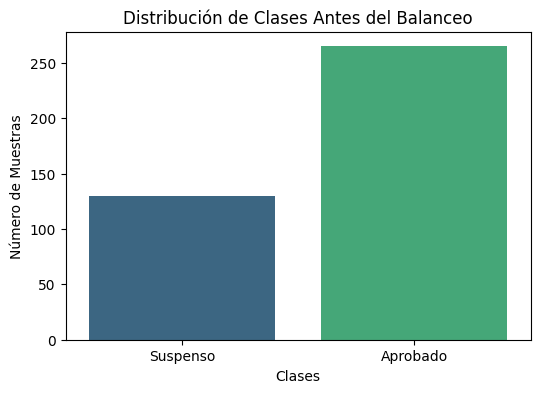

/var/folders/fm/9pzntrns5_s8x46kp5sm9x240000gn/T/ipykernel_17148/3324153114.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_balanced, palette='viridis')


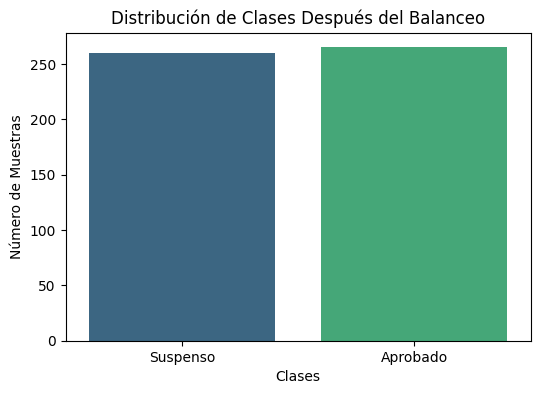

/var/folders/fm/9pzntrns5_s8x46kp5sm9x240000gn/T/ipykernel_17148/3324153114.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_balanced.assign(Clase=y_balanced), x='Clase', y=X.columns[0], palette='viridis')


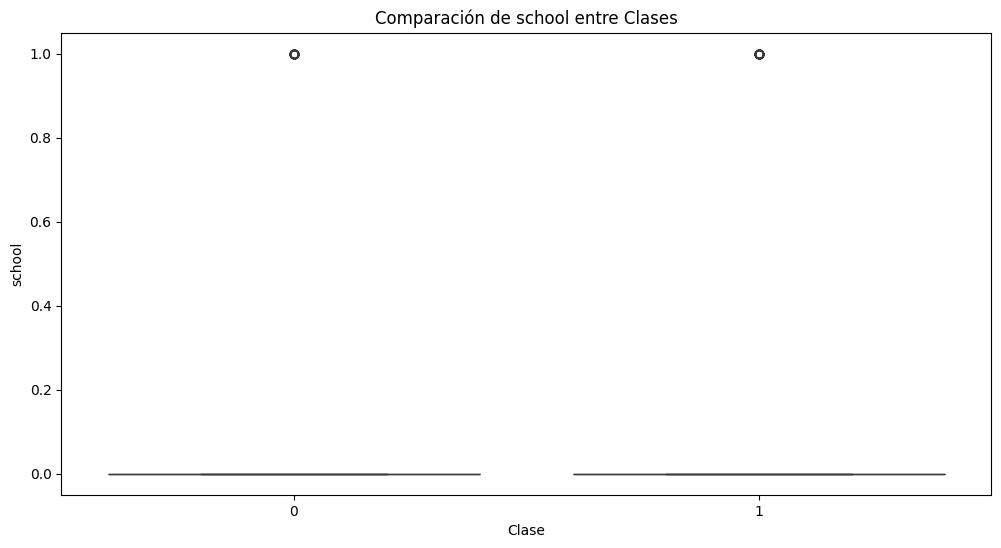

Evaluación de m:


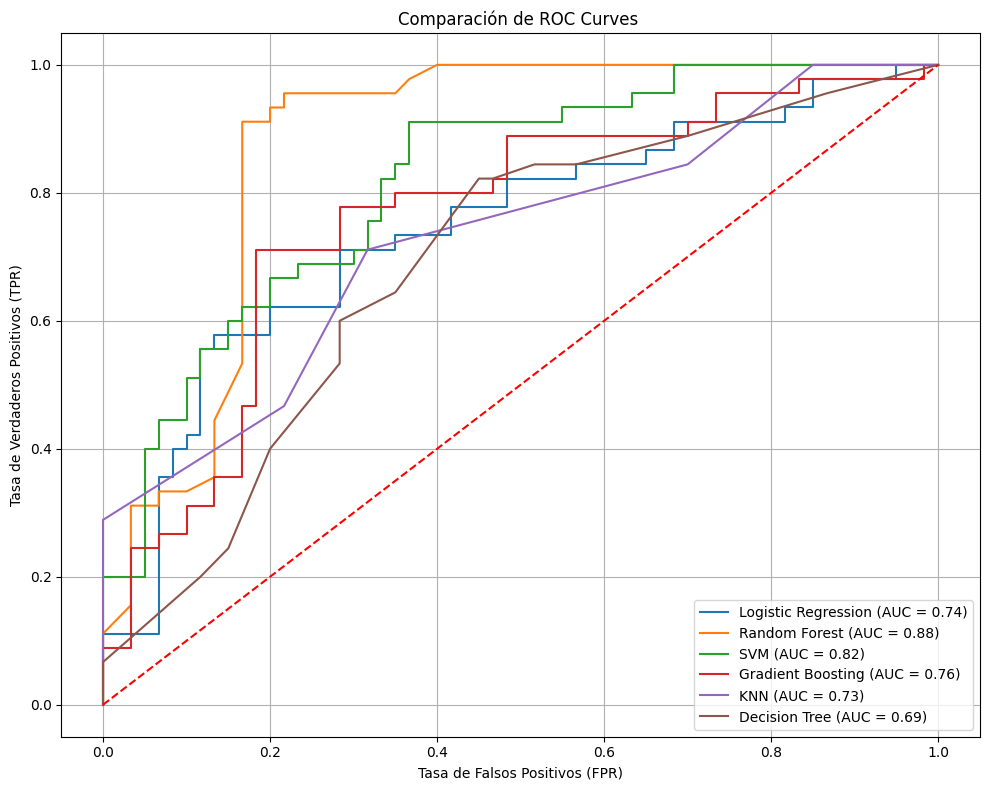

Evaluación con datos transformados (PowerTransformer):


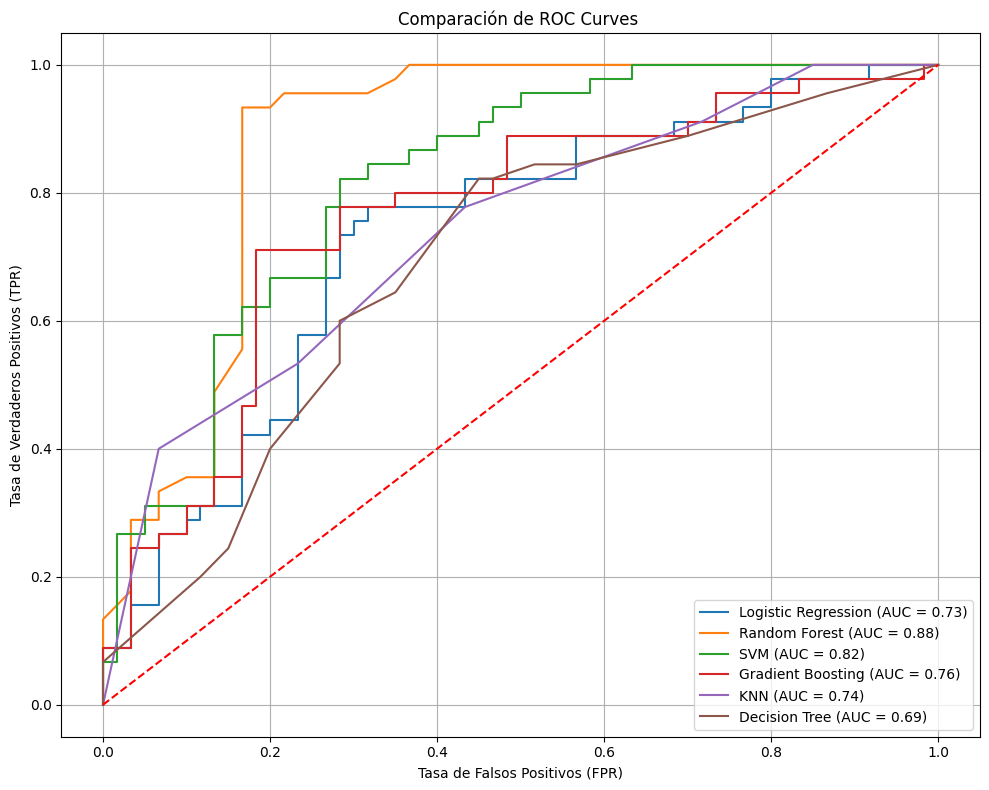

In [18]:
# Importar librías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importar datos
df = pd.read_csv('student-mat.csv')

# 2. Preprocesamiento de datos
# Codificar variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Separar variables predictoras y objetivo (binarización de G3)
X = df.drop(['G3', 'G2', 'G1'], axis=1)
y = (df['G3'] >= 10).astype(int)  # 1: Aprobado, 0: Suspenso

# Gráfico de distribución de clases antes del balanceo
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='viridis')
plt.title("Distribución de Clases Antes del Balanceo")
plt.xlabel("Clases")
plt.ylabel("Número de Muestras")
plt.xticks(ticks=[0, 1], labels=["Suspenso", "Aprobado"])
plt.show()

# Balancear manualmente las clases
y_counts = y.value_counts()
majority_class = y_counts.idxmax()
minority_class = y_counts.idxmin()

# Obtener las muestras de la clase minoritaria y duplicarlas
minority_indices = y[y == minority_class].index
additional_minority_samples = X.loc[minority_indices]
X_balanced = pd.concat([X, additional_minority_samples], axis=0)
y_balanced = pd.concat([y, pd.Series([minority_class] * len(minority_indices), index=additional_minority_samples.index)])

# Gráfico de distribución de clases después del balanceo
plt.figure(figsize=(6, 4))
sns.countplot(x=y_balanced, palette='viridis')
plt.title("Distribución de Clases Después del Balanceo")
plt.xlabel("Clases")
plt.ylabel("Número de Muestras")
plt.xticks(ticks=[0, 1], labels=["Suspenso", "Aprobado"])
plt.show()

# Comparación de características principales entre clases
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_balanced.assign(Clase=y_balanced), x='Clase', y=X.columns[0], palette='viridis')
plt.title(f"Comparación de {X.columns[0]} entre Clases")
plt.xlabel("Clase")
plt.ylabel(X.columns[0])
plt.show()

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar PowerTransformer para comparar después
pt = PowerTransformer(method='yeo-johnson')
X_train_pt = pt.fit_transform(X_train)
X_test_pt = pt.transform(X_test)

# 3. Definición de modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42)
}

# 4. Función para evaluación con ROC Curve
def evaluate_models_with_roc(models, X_train, y_train, X_test, y_test, title_suffix=''):
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        # Entrenamiento del modelo
        model.fit(X_train, y_train)
        
        # Probabilidades para la clase positiva
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.decision_function(X_test)
        
        # Calcular ROC Curve y AUC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        
        # Graficar la ROC Curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    
    # Personalización del gráfico
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea aleatoria
    plt.title(f'Comparación de ROC Curves ')
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

# 5. Evaluación con y sin PowerTransformer
print("Evaluación de m:")
evaluate_models_with_roc(models, X_train_scaled, y_train, X_test_scaled, y_test, title_suffix="(StandardScaler)")

print("Evaluación con datos transformados (PowerTransformer):")
evaluate_models_with_roc(models, X_train_pt, y_train, X_test_pt, y_test, title_suffix="(PowerTransformer)")


In [11]:


# Verificar balance de clases
print("Distribución de clases antes de SMOTE:")
print(y.value_counts())

# Ajustar k_neighbors dinámicamente según el número de muestras de la clase minoritaria
minority_class_count = y.value_counts().min()
k_neighbors = min(5, minority_class_count - 1)  # k_neighbors no puede ser mayor que el tamaño de la clase minoritaria

if k_neighbors < 1:
    raise ValueError("No hay suficientes muestras en la clase minoritaria para aplicar SMOTE.")

# Balanceo de clases con SMOTE
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Verificar balance de clases después de SMOTE
print("Distribución de clases después de SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Normalización/Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.3, random_state=42)

# Modelos a entrenar
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Crear la curva ROC
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Línea base
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparación de ROC Curves')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Distribución de clases antes de SMOTE:
G3
10    54
11    45
0     38
15    33
8     30
12    29
13    27
14    26
9     24
16    16
6     15
18    12
5      7
17     6
7      6
19     5
20     1
4      1
Name: count, dtype: int64


ValueError: No hay suficientes muestras en la clase minoritaria para aplicar SMOTE.

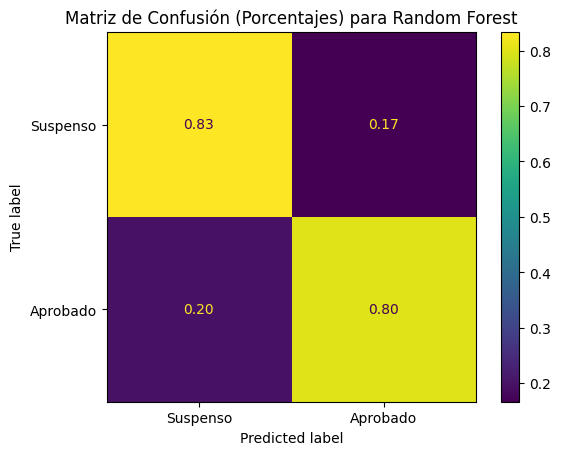

In [20]:
# 6. Matriz de confusión para Random Forest con porcentajes
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred_rf, normalize='true')  # Normalizar para obtener porcentajes
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Suspenso", "Aprobado"])
cmd.plot(cmap='viridis', values_format=".2f")  # Mostrar valores como porcentajes con 2 decimales
plt.title("Matriz de Confusión (Porcentajes) para Random Forest")
plt.show()


/var/folders/fm/9pzntrns5_s8x46kp5sm9x240000gn/T/ipykernel_17148/3624068140.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


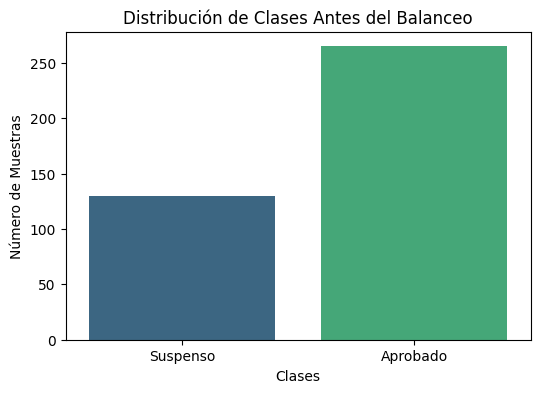

/var/folders/fm/9pzntrns5_s8x46kp5sm9x240000gn/T/ipykernel_17148/3624068140.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_balanced, palette='viridis')


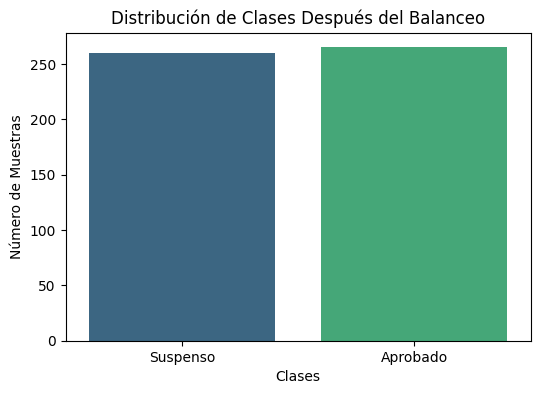

/var/folders/fm/9pzntrns5_s8x46kp5sm9x240000gn/T/ipykernel_17148/3624068140.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_balanced.assign(Clase=y_balanced), x='Clase', y=X.columns[0], palette='viridis')


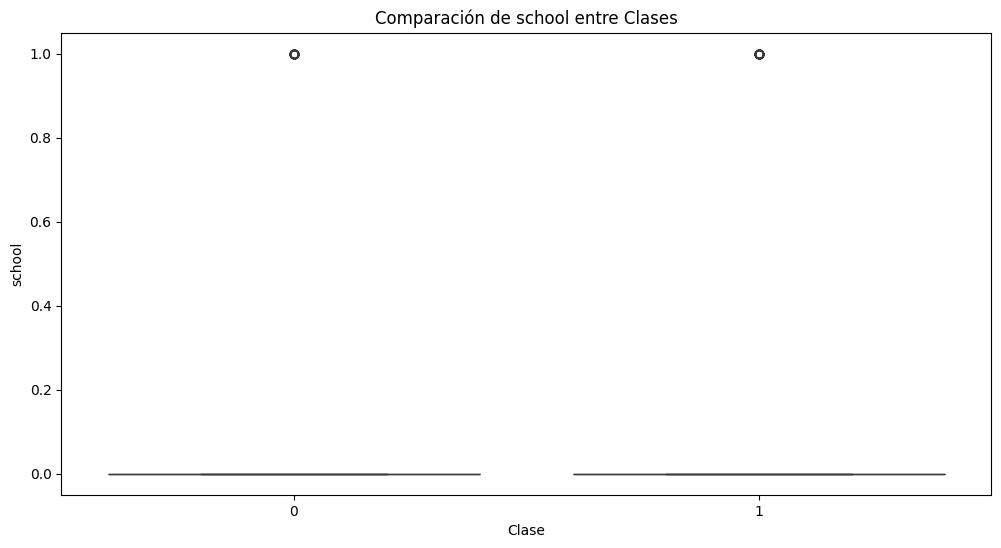

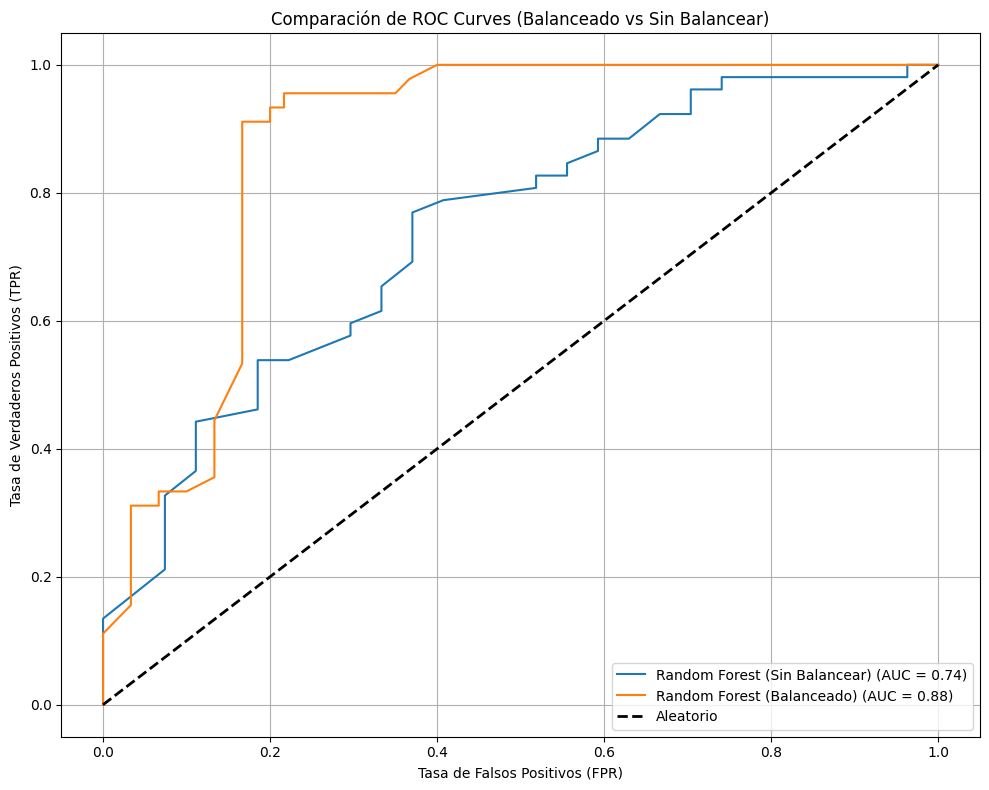

In [21]:
# Importar librías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importar datos
df = pd.read_csv('student-mat.csv')

# 2. Preprocesamiento de datos
# Codificar variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Separar variables predictoras y objetivo (binarización de G3)
X = df.drop(['G3', 'G2', 'G1'], axis=1)
y = (df['G3'] >= 10).astype(int)  # 1: Aprobado, 0: Suspenso

# Gráfico de distribución de clases antes del balanceo
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='viridis')
plt.title("Distribución de Clases Antes del Balanceo")
plt.xlabel("Clases")
plt.ylabel("Número de Muestras")
plt.xticks(ticks=[0, 1], labels=["Suspenso", "Aprobado"])
plt.show()

# Balancear manualmente las clases
y_counts = y.value_counts()
majority_class = y_counts.idxmax()
minority_class = y_counts.idxmin()

# Obtener las muestras de la clase minoritaria y duplicarlas
minority_indices = y[y == minority_class].index
additional_minority_samples = X.loc[minority_indices]
X_balanced = pd.concat([X, additional_minority_samples], axis=0)
y_balanced = pd.concat([y, pd.Series([minority_class] * len(minority_indices), index=additional_minority_samples.index)])

# Gráfico de distribución de clases después del balanceo
plt.figure(figsize=(6, 4))
sns.countplot(x=y_balanced, palette='viridis')
plt.title("Distribución de Clases Después del Balanceo")
plt.xlabel("Clases")
plt.ylabel("Número de Muestras")
plt.xticks(ticks=[0, 1], labels=["Suspenso", "Aprobado"])
plt.show()

# Comparación de características principales entre clases
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_balanced.assign(Clase=y_balanced), x='Clase', y=X.columns[0], palette='viridis')
plt.title(f"Comparación de {X.columns[0]} entre Clases")
plt.xlabel("Clase")
plt.ylabel(X.columns[0])
plt.show()

# División en entrenamiento y prueba (sin balancear)
X_train_unbalanced, X_test_unbalanced, y_train_unbalanced, y_test_unbalanced = train_test_split(X, y, test_size=0.2, random_state=42)

# División en entrenamiento y prueba (balanceado)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Escalar los datos (sin balancear)
scaler = StandardScaler()
X_train_unbalanced_scaled = scaler.fit_transform(X_train_unbalanced)
X_test_unbalanced_scaled = scaler.transform(X_test_unbalanced)

# Escalar los datos (balanceado)
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_test_balanced_scaled = scaler.transform(X_test_balanced)

# Función para graficar ROC Curve para un modelo

def plot_roc_curve(model, X_train, y_train, X_test, y_test, title):
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{title} (AUC = {auc:.2f})")

# Modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
plt.figure(figsize=(10, 8))

# ROC Curve para datos sin balancear
plot_roc_curve(rf_model, X_train_unbalanced_scaled, y_train_unbalanced, X_test_unbalanced_scaled, y_test_unbalanced, "Random Forest (Sin Balancear)")

# ROC Curve para datos balanceados
plot_roc_curve(rf_model, X_train_balanced_scaled, y_train_balanced, X_test_balanced_scaled, y_test_balanced, "Random Forest (Balanceado)")

plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Aleatorio")
plt.title("Comparación de ROC Curves (Balanceado vs Sin Balancear)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


/var/folders/fm/9pzntrns5_s8x46kp5sm9x240000gn/T/ipykernel_17148/3579000433.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


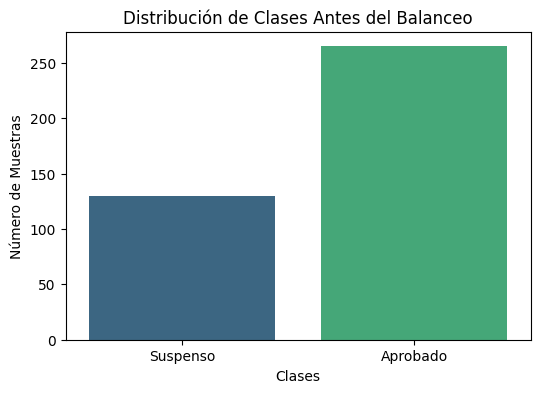

/var/folders/fm/9pzntrns5_s8x46kp5sm9x240000gn/T/ipykernel_17148/3579000433.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_balanced, palette='viridis')


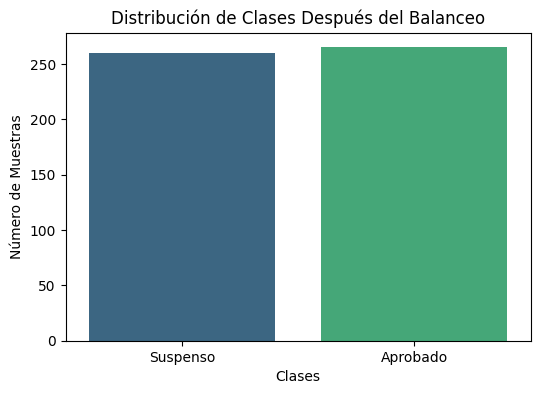

Random Forest - Validación Cruzada (Sin Balancear):
Accuracy: 0.71 ± 0.04
Random Forest - Validación Cruzada (Balanceado):
Accuracy: 0.79 ± 0.04

Métricas Sin Balancear:
Accuracy: 0.71
Precision: 0.72
Recall: 0.92
F1 Score: 0.81

Métricas Balanceado:
Accuracy: 0.79
Precision: 0.80
Recall: 0.81
F1 Score: 0.80


In [23]:
# Importar librías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importar datos
df = pd.read_csv('student-mat.csv')

# 2. Preprocesamiento de datos
# Codificar variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Separar variables predictoras y objetivo (binarización de G3)
X = df.drop(['G3', 'G2', 'G1'], axis=1)
y = (df['G3'] >= 10).astype(int)  # 1: Aprobado, 0: Suspenso

# Gráfico de distribución de clases antes del balanceo
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='viridis')
plt.title("Distribución de Clases Antes del Balanceo")
plt.xlabel("Clases")
plt.ylabel("Número de Muestras")
plt.xticks(ticks=[0, 1], labels=["Suspenso", "Aprobado"])
plt.show()

# Balancear manualmente las clases
y_counts = y.value_counts()
majority_class = y_counts.idxmax()
minority_class = y_counts.idxmin()

# Obtener las muestras de la clase minoritaria y duplicarlas
minority_indices = y[y == minority_class].index
additional_minority_samples = X.loc[minority_indices]
X_balanced = pd.concat([X, additional_minority_samples], axis=0)
y_balanced = pd.concat([y, pd.Series([minority_class] * len(minority_indices), index=additional_minority_samples.index)])

# Gráfico de distribución de clases después del balanceo
plt.figure(figsize=(6, 4))
sns.countplot(x=y_balanced, palette='viridis')
plt.title("Distribución de Clases Después del Balanceo")
plt.xlabel("Clases")
plt.ylabel("Número de Muestras")
plt.xticks(ticks=[0, 1], labels=["Suspenso", "Aprobado"])
plt.show()

# División en entrenamiento y prueba (sin balancear)
X_train_unbalanced, X_test_unbalanced, y_train_unbalanced, y_test_unbalanced = train_test_split(X, y, test_size=0.2, random_state=42)

# División en entrenamiento y prueba (balanceado)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_unbalanced_scaled = scaler.fit_transform(X_train_unbalanced)
X_test_unbalanced_scaled = scaler.transform(X_test_unbalanced)
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_test_balanced_scaled = scaler.transform(X_test_balanced)

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Validación cruzada sin balancear
scores_unbalanced = cross_val_score(rf_model, X_train_unbalanced_scaled, y_train_unbalanced, cv=cv, scoring='accuracy')
print("Random Forest - Validación Cruzada (Sin Balancear):")
print(f"Accuracy: {np.mean(scores_unbalanced):.2f} ± {np.std(scores_unbalanced):.2f}")

# Validación cruzada balanceada
scores_balanced = cross_val_score(rf_model, X_train_balanced_scaled, y_train_balanced, cv=cv, scoring='accuracy')
print("Random Forest - Validación Cruzada (Balanceado):")
print(f"Accuracy: {np.mean(scores_balanced):.2f} ± {np.std(scores_balanced):.2f}")

# Métricas con predicción de validación cruzada
y_pred_unbalanced = cross_val_predict(rf_model, X_train_unbalanced_scaled, y_train_unbalanced, cv=cv)
y_pred_balanced = cross_val_predict(rf_model, X_train_balanced_scaled, y_train_balanced, cv=cv)

print("\nMétricas Sin Balancear:")
print(f"Accuracy: {accuracy_score(y_train_unbalanced, y_pred_unbalanced):.2f}")
print(f"Precision: {precision_score(y_train_unbalanced, y_pred_unbalanced):.2f}")
print(f"Recall: {recall_score(y_train_unbalanced, y_pred_unbalanced):.2f}")
print(f"F1 Score: {f1_score(y_train_unbalanced, y_pred_unbalanced):.2f}")

print("\nMétricas Balanceado:")
print(f"Accuracy: {accuracy_score(y_train_balanced, y_pred_balanced):.2f}")
print(f"Precision: {precision_score(y_train_balanced, y_pred_balanced):.2f}")
print(f"Recall: {recall_score(y_train_balanced, y_pred_balanced):.2f}")
print(f"F1 Score: {f1_score(y_train_balanced, y_pred_balanced):.2f}")


Evaluación sin class_weight:


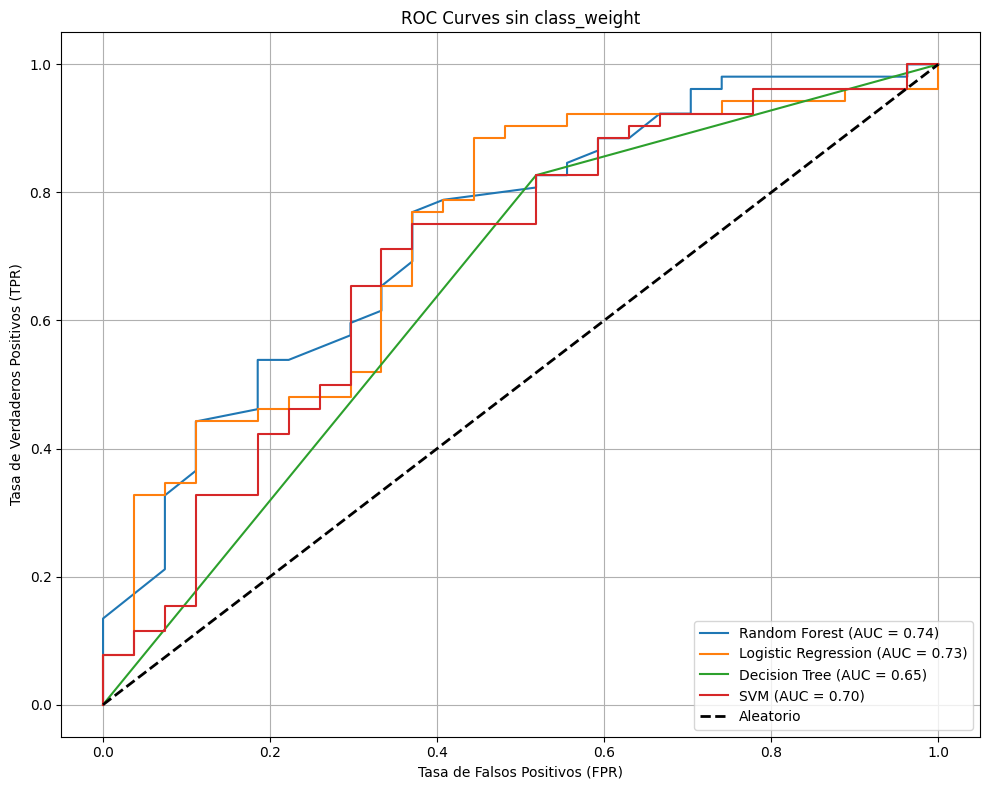

Evaluación con class_weight='balanced':


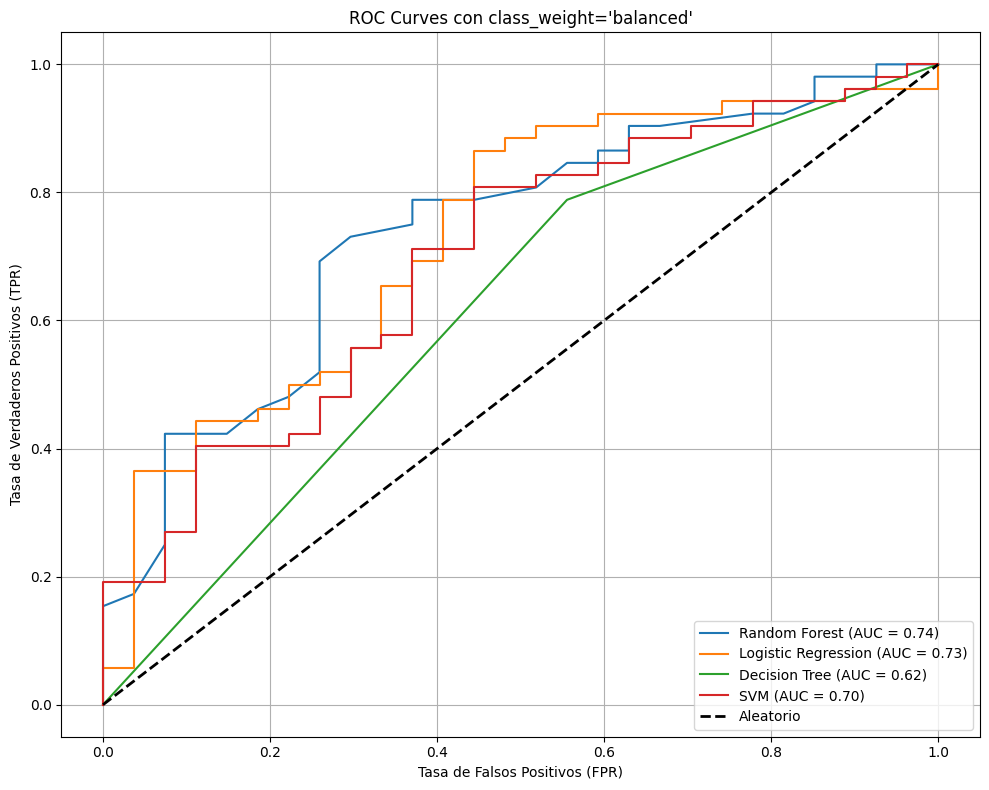

Reporte de Clasificación para Random Forest (Sin class_weight):
              precision    recall  f1-score   support

    Suspenso       0.80      0.30      0.43        27
    Aprobado       0.72      0.96      0.83        52

    accuracy                           0.73        79
   macro avg       0.76      0.63      0.63        79
weighted avg       0.75      0.73      0.69        79

Reporte de Clasificación para Random Forest (Con class_weight):
              precision    recall  f1-score   support

    Suspenso       0.56      0.19      0.28        27
    Aprobado       0.69      0.92      0.79        52

    accuracy                           0.67        79
   macro avg       0.62      0.55      0.53        79
weighted avg       0.64      0.67      0.61        79



In [22]:
# Importar librías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importar datos
df = pd.read_csv('student-mat.csv')

# 2. Preprocesamiento de datos
# Codificar variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Separar variables predictoras y objetivo (binarización de G3)
X = df.drop(['G3', 'G2', 'G1'], axis=1)
y = (df['G3'] >= 10).astype(int)  # 1: Aprobado, 0: Suspenso

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Definición de modelos sin balanceo
models_unbalanced = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

# 4. Definición de modelos con class_weight='balanced'
models_balanced = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
}

# 5. Evaluación y comparación
# Función para graficar ROC Curve para los modelos
def plot_roc_curves(models, X_train, y_train, X_test, y_test, title):
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.decision_function(X_test)
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Aleatorio")
    plt.title(title)
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()

# Comparar modelos sin y con class_weight='balanced'
print("Evaluación sin class_weight:")
plot_roc_curves(models_unbalanced, X_train_scaled, y_train, X_test_scaled, y_test, "ROC Curves sin class_weight")

print("Evaluación con class_weight='balanced':")
plot_roc_curves(models_balanced, X_train_scaled, y_train, X_test_scaled, y_test, "ROC Curves con class_weight='balanced'")

# Reporte de clasificación para Random Forest
print("Reporte de Clasificación para Random Forest (Sin class_weight):")
rf_unbalanced = models_unbalanced['Random Forest']
rf_unbalanced.fit(X_train_scaled, y_train)
y_pred_unbalanced = rf_unbalanced.predict(X_test_scaled)
print(classification_report(y_test, y_pred_unbalanced, target_names=["Suspenso", "Aprobado"]))

print("Reporte de Clasificación para Random Forest (Con class_weight):")
rf_balanced = models_balanced['Random Forest']
rf_balanced.fit(X_train_scaled, y_train)
y_pred_balanced = rf_balanced.predict(X_test_scaled)
print(classification_report(y_test, y_pred_balanced, target_names=["Suspenso", "Aprobado"]))
